In [156]:
import string
import re

import spacy
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.layers import Input, Embedding, Dropout, Dense
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, GlobalMaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

import tensorflow as tf
import io
from bs4 import BeautifulSoup

Proprocessing Pipeline

In [157]:
# English spacy model
nlp = spacy.load("en_core_web_sm")
# Stop word list from NLTK
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
stopword_list.append('@user')
stopword_list.append('url')
# Punctuation list from string
puncts = string.punctuation


In [158]:
# Kontraktionen exandieren -> Negation
def decontract_phrase(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"shan\'t", "shall not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not ", phrase)
    phrase = re.sub(r"\'re ", " are ", phrase)
    phrase = re.sub(r"\'s ", " is ", phrase)
    phrase = re.sub(r"\'d ", " would ", phrase)
    phrase = re.sub(r"\'ll ", " will ", phrase)
    phrase = re.sub(r"\'t ", " not ", phrase)
    phrase = re.sub(r"\'ve ", " have ", phrase)
    phrase = re.sub(r"\'m ", " am ", phrase)
    
    phrase = re.sub(r'\s+', ' ', phrase)

    return phrase

In [159]:
def get_lemma(review):
    doc = nlp(review)
    lemma_text = ' '.join([token.lemma_ for token in doc])
    
    return lemma_text


In [160]:
def preprocess_pipeline(review):
    # Kontraktionen expandieren
    review = decontract_phrase(review)
    # Tokenisierung und Lemmatisierung
    review = get_lemma(review)    
    # Stopwords
    review = ' '.join([token for token in review.split() if token.lower() not in stopword_list])
    # Satzzeichen
    review = ''.join([character for character in review if character not in puncts])
    # Remove multiple whitespaces
    review = re.sub(r'^\s+', '', review)
    review = re.sub(r' +', ' ', review)
    review = re.sub(r'\s+$', '', review)
    
    return review

test = ".@USER @USER and @USER MP @USER praises the 'innovative #publicsector thinking' of @USER this week in @USER  If Britain is to prosper in the 21st century, it is through embracing the #digital economy URL URL"
preprocess_pipeline(test)

'USER MP praise innovative publicsector think week Britain prosper 21st century embrace digital economy'

In [161]:
# Normalisation
def preprocess_pipe(text):
    # HTML
    new_string = BeautifulSoup(text, "lxml").text
    # contractions
    new_string = decontract_phrase(new_string)
    # Tokenisierung und Lemmatisierung
    new_string = get_lemma(new_string) 
    # Stop Words
    new_string = ' '.join(token for token in new_string.split() if token.lower() not in stopword_list)
    # remove everything not character, digit or whitespace
    new_string = re.sub(r'[^a-zA-Z0-9\s]', '', new_string)
    # remove multiple whitespaces
    new_string = re.sub(r' +', ' ', new_string)
    # 'tokenize' by whitespace
    new_string = new_string.split()
    
    return ' '.join(new_string)

test =  ".@USER @USER and @USER MP @USER praises the 'innovative #publicsector thinking' of @USER this week in @USER  If Britain is to prosper in the 21st century, it is through embracing the #digital economy URL URL"
preprocess_pipe(test)

'USER MP praise innovative publicsector think week Britain prosper 21st century embrace digital economy'

In [162]:
dataset_train = pd.read_csv('./Daten/Praktikum_OLID_train.csv')
dataset_dev = pd.read_csv('./Daten/Praktikum_OLID_dev.csv')
dataset_train.head()

,Text,Task
0,@USER bakkt is doing what an ETF would have do...,OFF
1,@USER I can't 😭😭 he is already 26,NOT
2,@USER he is a psychic ain’t he,NOT
3,.@USER @USER and @USER MP @USER praises the 'i...,NOT
4,@USER @USER [Eric opens the door and runs to t...,OFF


In [163]:
# Are all columns defined?
# Non-Null Count shows how many rows for each column are well-defined
dataset_train.info()
dataset_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10481 entries, 0 to 10480
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    10481 non-null  object
 1   Task    10481 non-null  object
dtypes: object(2)
memory usage: 163.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2620 entries, 0 to 2619
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2620 non-null   object
 1   Task    2620 non-null   object
dtypes: object(2)
memory usage: 41.1+ KB


In [164]:
dataset_train['Preprocessed'] = dataset_train['Text'].apply(preprocess_pipeline)
dataset_dev['Preprocessed'] = dataset_dev['Text'].apply(preprocess_pipeline)
dataset_train.info()
dataset_dev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10481 entries, 0 to 10480
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Text          10481 non-null  object
 1   Task          10481 non-null  object
 2   Preprocessed  10481 non-null  object
dtypes: object(3)
memory usage: 245.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2620 entries, 0 to 2619
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Text          2620 non-null   object
 1   Task          2620 non-null   object
 2   Preprocessed  2620 non-null   object
dtypes: object(3)
memory usage: 61.5+ KB


In [165]:
dataset_train['Task'].loc[dataset_train['Task']=="NOT"]=0.0
dataset_train['Task'].loc[dataset_train['Task']=="OFF"]=1.0

dataset_dev['Task'].loc[dataset_train['Task']=="NOT"]=0.0
dataset_dev['Task'].loc[dataset_train['Task']=="OFF"]=1.0

In [166]:
dataset_train.head()
#dataset_dev.head()

,Text,Task,Preprocessed
0,@USER bakkt is doing what an ETF would have do...,1.0,bakkt etf would not call etf FUKEN CUUUUUKS
1,@USER I can't 😭😭 he is already 26,0.0,not 😭 😭 already 26
2,@USER he is a psychic ain’t he,0.0,psychic ai not
3,.@USER @USER and @USER MP @USER praises the 'i...,0.0,USER MP praise innovative publicsector think w...
4,@USER @USER [Eric opens the door and runs to t...,1.0,Eric open door run couch fuck yeah


#### Beginn Sentiment Analysis CNN

In [167]:
# Colours
plot_rost = (236 / 255., 116 / 255., 5 / 255.)
plot_blue = (31 / 255., 119 / 255., 180 / 255.)
plot_green = (103 / 255., 191 / 255., 92 / 255.)
plot_grey = (207 / 255., 207 / 255., 207 / 255.)

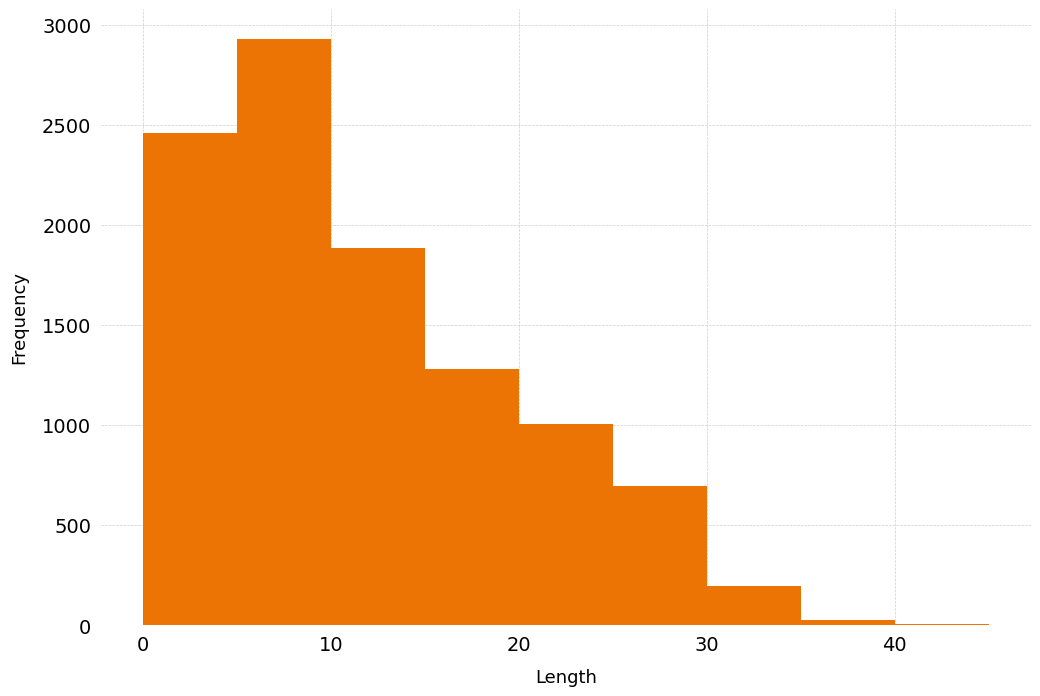

In [168]:
# Plot Distribution
reviews_length = [len(tweet.split()) for tweet in dataset_train['Preprocessed']]
plt.figure(figsize=(12,8))
plt.yticks(fontsize=14)    
plt.xticks(fontsize=14)
plt.hist(reviews_length, bins = np.arange(0,50,5), zorder=3, color=plot_rost) 
plt.xlabel('Length', fontsize=13, labelpad=10)
plt.ylabel('Frequency', fontsize=13, labelpad=10)
plt.grid(zorder=0, linewidth=0.5, linestyle='--', color=plot_grey)
plt.tick_params(axis="both", bottom=False, left=False)
plt.box(on=None)
#plt.savefig('./SentencePolarity_review_length.png', dpi=500, transparent=False, bbox_inches='tight')
plt.show()

In [169]:
# Tokenizer without restriction
tokenizer = Tokenizer()
# Tokenizer fitten 
tokenizer.fit_on_texts(dataset_train['Preprocessed'])

# Length of vocabulary
word_index = tokenizer.word_index
print('Unique Tokens: {}'.format(len(word_index)))

Unique Tokens: 15423


In [170]:
# maximal numbers of features
max_features = 15000

# Tokenizer mit num_words = max_features
tokenizer = Tokenizer(num_words=max_features)
# Tokenizer fitten 
tokenizer.fit_on_texts(dataset_train['Preprocessed'])

# Tokenizer anwenden
sequences = tokenizer.texts_to_sequences(dataset_train['Preprocessed'])

print(sequences[1])
print(sequences[10])

[1, 257, 257, 169, 2167]
[321, 31]


In [171]:
# max_length festlegen
max_length = 40

X = pad_sequences(sequences, maxlen=max_length)

In [172]:
# Convert labels to array
y = np.asarray(dataset_train['Task']).astype("float64")

# Print shapes
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (10481, 40)
Shape of label tensor: (10481,)


In [173]:
%%time
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('./Daten/crawl-300d-2M.vec/crawl-300d-2M.vec')

embedding_dim = 300
vocabulary_size = min(len(word_index)+1, max_features)
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))

for word, i in word_index.items():
    if i >= max_features:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = word_vectors['unk']

CPU times: user 3min 5s, sys: 2.71 s, total: 3min 8s
Wall time: 3min 11s


In [174]:
def cnn_model():
    
    # Input Layer
    input_layer = Input(shape=(max_length, ), dtype='int64')
    
    # Embedding Layer mit Gewichten aus der embedding_matrix
    embedding_layer = Embedding(max_features, embedding_dim, input_length=max_length, 
                                weights=[embedding_matrix])(input_layer)
    
    # Generate Convolutional Layers
    conv_layers = list()
    kernels = [3,4,5]
    for kernel in kernels:
        conv1d = Conv1D(100, kernel_size=kernel, padding='same', activation='relu')(embedding_layer)
        glbmax1d = GlobalMaxPooling1D()(conv1d)
        conv_layers.append(glbmax1d)
    
    # Concatenate
    conc_layer = concatenate(conv_layers, axis=1)
    
    # Fully Connected layer
    drop_1 = Dropout(0.5)(conc_layer)
    dense_1 = Dense(100)(drop_1)
    
    # Output Layer
    output_layer = Dense(1, activation='sigmoid')(dense_1)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    #Adam = F1 0.62
    adam = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    amsgrad=False,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name='Adam'
)

    #AdaDelta = F1 0.03 Shit
    adadelta = tf.keras.optimizers.experimental.Adadelta(
    learning_rate=0.001,
    rho=0.95,
    epsilon=1e-07,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name='Adadelta'
)

    #AdaFactor = F1 0.58
    adafactor = tf.keras.optimizers.Adafactor(
    learning_rate=0.001,
    beta_2_decay=-0.8,
    epsilon_1=1e-30,
    epsilon_2=0.001,
    clip_threshold=1.0,
    relative_step=True,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name='Adafactor'

)

    #AdaMax = F1 0.62
    adamax = tf.keras.optimizers.experimental.Adamax(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    weight_decay=None,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name='Adamax',
)

    # Compile Model
    model.compile(optimizer=adamax, loss='binary_focal_crossentropy', metrics=['accuracy'])
    
    return model

Model: "model_85"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_86 (InputLayer)          [(None, 40)]         0           []                               
                                                                                                  
 embedding_85 (Embedding)       (None, 40, 300)      4500000     ['input_86[0][0]']               
                                                                                                  
 conv1d_255 (Conv1D)            (None, 40, 100)      90100       ['embedding_85[0][0]']           
                                                                                                  
 conv1d_256 (Conv1D)            (None, 40, 100)      120100      ['embedding_85[0][0]']           
                                                                                           

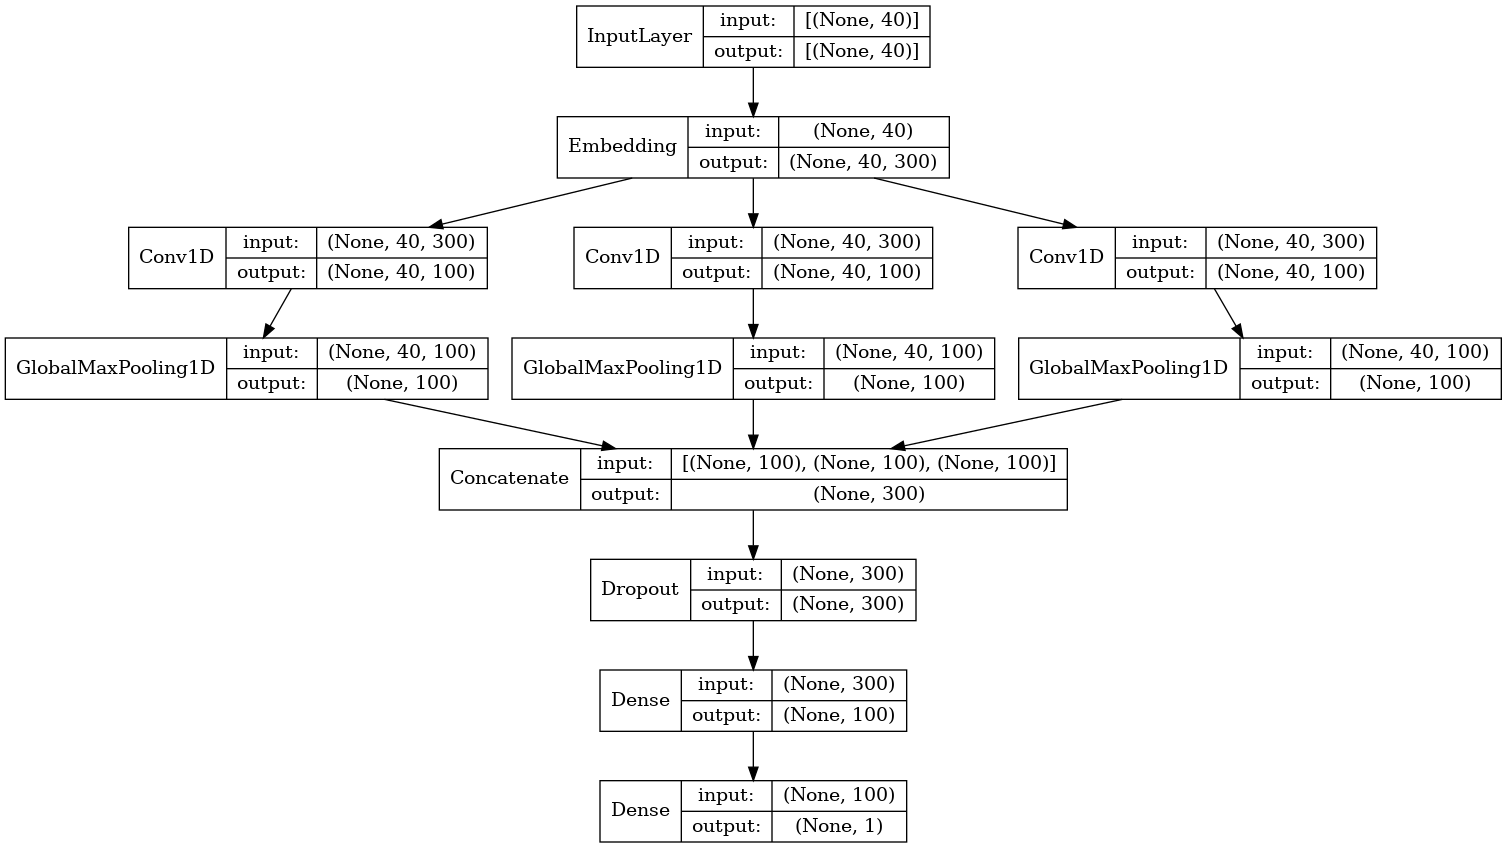

In [175]:
# Summary
model = cnn_model()
model.summary()

# Plot Model
plot_model(model, show_layer_names=False)
plot_model(model, show_shapes=True, show_layer_names=False)

#### Fortsetzung Modell

In [176]:
cnt_vec = CountVectorizer()
X_cnt_train = cnt_vec.fit_transform(dataset_train['Preprocessed'])
X_cnt_dev = cnt_vec.fit_transform(dataset_dev['Preprocessed'])
print(X_cnt_train.shape)
print(X_cnt_dev.shape)

(10481, 14992)
(2620, 6598)


In [177]:
dataset_train['char_count'] = dataset_train['Text'].apply(len)
dataset_train['word_count'] = dataset_train['Text'].apply(lambda x: len(x.split()))
dataset_train['Density'] = dataset_train['char_count'] / (dataset_train['word_count']+1)
dataset_train['punctuation_count'] = dataset_train['Text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))
dataset_train['Punct_Count_Ratio'] = dataset_train['punctuation_count'] / dataset_train['word_count']

dataset_dev['char_count'] = dataset_dev['Text'].apply(len)
dataset_dev['word_count'] = dataset_dev['Text'].apply(lambda x: len(x.split()))
dataset_dev['Density'] = dataset_dev['char_count'] / (dataset_dev['word_count']+1)
dataset_dev['punctuation_count'] = dataset_dev['Text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))
dataset_dev['Punct_Count_Ratio'] = dataset_dev['punctuation_count'] / dataset_dev['word_count']

In [178]:
dataset_train.head()
dataset_dev.head()

,Text,Task,Preprocessed,char_count,word_count,Density,punctuation_count,Punct_Count_Ratio
0,. @USER @USER @USER @USER Fake conservatives a...,NOT,fake conservative fake outrage budget betrayal,100,17,5.555556,5,0.294118
1,@USER @USER You are sick in the head. This man...,OFF,sick head man lose daughter,65,13,4.642857,4,0.307692
2,🛑 Truthfeed News 🛑 👉 'Schumer and Feinstein Go...,NOT,🛑 Truthfeed News 🛑 👉 Schumer Feinstein Go HYST...,134,21,6.090909,5,0.238095
3,@USER @USER best lead @USER &amp; @USER most u...,NOT,good lead amp underrate,55,9,5.500000,6,0.666667
4,@USER @USER The liberals can never handle the ...,OFF,liberal never handle truth truth make head 💥 💥...,90,15,5.625000,5,0.333333


In [179]:
X_dense_train = X_cnt_train.toarray()
X_dense_dev = X_cnt_dev.toarray()

X_ling_train = np.vstack((dataset_train['Density'], 
                    dataset_train['Punct_Count_Ratio'])).T
X_ling_dev = np.vstack((dataset_dev['Density'], 
                    dataset_dev['Punct_Count_Ratio'])).T

scaler = MinMaxScaler()
X_ling_scale_train = scaler.fit_transform(X_ling_train)
X_ling_scale_dev = scaler.fit_transform(X_ling_dev)
X_train = np.hstack((X_dense_train, X_ling_scale_train))
X_dev = np.hstack((X_dense_dev, X_ling_scale_dev))

print(X_train.shape)
print(X_dev.shape)

(10481, 14994)
(2620, 6600)


In [180]:
# Encode Labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(dataset_train['Task'])
y_dev = encoder.fit_transform(dataset_dev['Task'])

print(y_train.shape)
print(y_dev.shape)
print(y_train[1:100])
print(y_dev[1:100])

(10481,)
(2620,)
[0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 1 0 0 1
 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0]
[1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 1 1
 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0]


In [181]:
seed = 1
# k-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

history_list = list()
evaluation_list = list()

for fold, [train, test] in enumerate(kfold.split(X, y)):
    
    # Load Model
    model = cnn_model()
    
    print('\n>>> Training | Fold {}'.format(fold+1))
    
    # Test
    X_test = X[test]
    y_test = y[test]
        
    # Callbacks
    path = './models/SentencePolarity_CNN_word_model_fold-{}.hdf5'.format(fold+1)
    checkpoint = ModelCheckpoint(path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=2)
    callbacks_list = [checkpoint]
    
    # Fit Model
    history = model.fit(X[train], y[train], validation_split=0.1,
                        epochs=10, batch_size=100, shuffle=True, callbacks=callbacks_list)
    
    # Append History
    history_list.append(history)

    # Load Best Model
    best_model = load_model(path)
    
    # Evaluate Model
    evaluation = best_model.evaluate(X_test, y_test)
    accuracy = round(evaluation[1], 3)
    loss = round(evaluation[0], 3)
    print('Accuracy: {} | Loss: {}\n'.format(accuracy, loss))
    
    # Precision, Recall, F1-Score
    y_values = best_model.predict(X_test)
    y_pred = [1 if y >= 0.5 else 0 for y in y_values]
    precision = round(precision_score(y_test, y_pred, average='binary'), 3)
    recall = round(recall_score(y_test, y_pred, average='binary'), 3)
    f1 = round(f1_score(y_test, y_pred, average='binary'), 3)
    print('Precision: {} | Recall: {} | F1-Score: {}'.format(precision, recall, f1))
    
    # Append Results
    evaluation_list.append([fold+1, accuracy, loss, precision, recall, f1])
    
    # Delete Model
    del model
    del history


>>> Training | Fold 1
Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.6013 - accuracy: 0.6965
Epoch 1: val_accuracy improved from -inf to 0.75530, saving model to ./models/SentencePolarity_CNN_word_model_fold-1.hdf5
85/85 [==============================] - 6s 63ms/step - loss: 0.6013 - accuracy: 0.6965 - val_loss: 0.5209 - val_accuracy: 0.7553
Epoch 2/10
85/85 [==============================] - ETA: 0s - loss: 0.4759 - accuracy: 0.7780
Epoch 2: val_accuracy improved from 0.75530 to 0.77119, saving model to ./models/SentencePolarity_CNN_word_model_fold-1.hdf5
85/85 [==============================] - 5s 60ms/step - loss: 0.4759 - accuracy: 0.7780 - val_loss: 0.4957 - val_accuracy: 0.7712
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.4155 - accuracy: 0.8164
Epoch 3: val_accuracy improved from 0.77119 to 0.77648, saving model to ./models/SentencePolarity_CNN_word_model_fold-1.hdf5
85/85 [==============================] - 5s 61ms/step - loss: 0

In [182]:
# Export Results
acc_avg = [i[1] for i in evaluation_list]
loss_avg = [i[2] for i in evaluation_list]
prec_avg = [i[3] for i in evaluation_list]
recall_avg = [i[4] for i in evaluation_list]
f1_avg = [i[5] for i in evaluation_list]

evaluation_list.append(['AVG',
                        round(np.mean(acc_avg), 4),
                        round(np.mean(loss_avg), 4), 
                        round(np.mean(prec_avg), 4),
                        round(np.mean(recall_avg), 4),
                        round(np.mean(f1_avg), 4)])


evaluation_df = pd.DataFrame(evaluation_list, columns=['Fold', 'Accuracy', 'Loss', 'Precision', 'Recall', 'F1-Score'])
#evaluation_df.to_csv('./Wine_SVM_evaluation.csv', index=False, sep=';')
print(evaluation_df)

   Fold  Accuracy    Loss  Precision  Recall  F1-Score
0     1    0.7850  0.5140     0.7160  0.5750    0.6380
1     2    0.7720  0.4820     0.6810  0.5810    0.6270
2     3    0.7830  0.4790     0.7020  0.5980    0.6460
3     4    0.7710  0.5030     0.6870  0.5590    0.6170
4     5    0.7870  0.4960     0.7190  0.5800    0.6420
5     6    0.7760  0.4820     0.6850  0.5910    0.6350
6     7    0.7780  0.4880     0.7060  0.5570    0.6220
7     8    0.7850  0.5220     0.7140  0.5800    0.6400
8     9    0.7750  0.4740     0.7100  0.5330    0.6090
9    10    0.7600  0.5770     0.6650  0.5420    0.5970
10  AVG    0.7772  0.5017     0.6985  0.5696    0.6273
